In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

In [2]:
# 1. Read data.
# 2. Check data.
# 3. Prepare model(geometry).
# 4. Interpolate missing values.
# 5. Visualize output.

In [3]:
# 1. Read data.

df = pd.read_csv('prepared_data_mercury_concentrations_volumetric.csv', sep=',', encoding='utf8', index_col='id')
gdf = gpd.read_file('input/italy_coastline.shp')
gdf.set_index('id', inplace=True)

In [4]:
# 2. Check data - as a table.

df.head()

,lon,lat,depth_m,mea_ug_kg_orig
id,,,,
1169,12.498515,44.911262,5.0,114.0
1589,12.498515,44.911262,5.0,422.0
9577,14.035094,43.812991,5.0,22.0
9578,14.035094,43.812991,5.0,23.0
9579,14.035094,43.812991,5.0,23.0


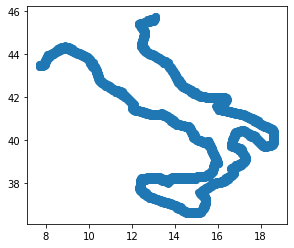

In [5]:
# 2. Check data - as a geometry.

gdf.plot();

In [6]:
gdf.geometry

id
1204      MULTIPOINT (13.07189 45.77755)
1205      MULTIPOINT (13.12189 45.77755)
2037      MULTIPOINT (13.02189 45.72755)
2038      MULTIPOINT (13.07189 45.72755)
2039      MULTIPOINT (13.12189 45.72755)
                       ...              
154698    MULTIPOINT (14.97189 36.57755)
154699    MULTIPOINT (15.02189 36.57755)
154700    MULTIPOINT (15.07189 36.57755)
154701    MULTIPOINT (15.12189 36.57755)
154702    MULTIPOINT (15.17189 36.57755)
Name: geometry, Length: 2990, dtype: geometry

In [7]:
# 3. Prepare model(geometry).

# For each point add depth profile - create new dataframe with those points

def build_volumetric_profile_array(points):
    """Function adds depth levels to the coastline geometry"""
    ranges = np.arange(0, 21, 5)
    mpts = []
    for r in ranges:
        vals = [points[0].x, points[0].y, r]
        mpts.append(vals)
    return np.array(mpts)

# 4. Interpolate missing values.
# 4. Calculate distances between 3D coordinates list and unknown point. Use numpy array operations.

def calculate_distances(coordinates, unknown_point):
    # Get coordinates dimension
    coordinates_dim = coordinates.shape[1]  # Number of columns in numpy array / Number of dimensions
    
    distances_between_dims = []
    
    for i in range(coordinates_dim):
        distance = (coordinates[:, i] - unknown_point[i])**2
        distances_between_dims.append(distance)
    
    dists_array = np.sqrt(np.sum(distances_between_dims, axis=0))
    
    return dists_array

In [8]:
def inverse_distance_weighting(unknown_point, points, power, ndist=10):
    """
    Function estimates values in unknown points with with inverse weighted interpolation technique.
    
    INPUT:
    :param unknown_point: coordinates of unknown point,
    :param points: (array) list of points and they values [dim 1, ..., dim n, val],
    :param power: (float) constant used to calculate IDW weight -> weight = 1/(distance**power),
    :param ndist: (int) how many closest distances are included in weighting,
    
    OUTPUT:
    :return interpolated_value: (float) interpolated value by IDW method.
    
    Inverse distance weighted interpolation is:
    
    est = SUM(WEIGHTS * KNOWN VALS) / SUM(WEIGHTS)
    and
    WEIGHTS = 1 / (DISTANCE TO UNKNOWN**power)
    
    where:
    power is a constant hyperparameter which tells how much point is influenced by other points. 
    """

    distances = calculate_distances(points[:, :-1], unknown_point)
    vals_and_dists = np.c_[points[:, -1], distances]
    
    # Sort and get only 10 values
    vals_and_dists = vals_and_dists[vals_and_dists[:, 1].argsort()]
    vals_for_idw = vals_and_dists[:ndist, :]
    
    # Check if first distance is 0
    if vals_for_idw[0, 1] == 0:
        # If first distance is 0 then return first value
        return vals_for_idw[0, 0]
    else:
        # If it's not perform calculations
        weights = 1 / (vals_for_idw[:, 1]**power)
        numerator = weights * vals_for_idw[:, 0]
        interpolated_value = np.sum(numerator) / np.sum(weights)
        return interpolated_value

In [9]:
def interpolate_values(array_of_coordinates, array_of_known_points):
    output_arr = []
    
    for row in array_of_coordinates:
        pts = build_volumetric_profile_array(row[0])
        for pt in pts:
            interpolated = inverse_distance_weighting(pt, array_of_known_points, power=3, ndist=5)
            interpol_arr = np.zeros(shape=(1, len(pt) + 1))
            interpol_arr[:, :-1] = pt
            interpol_arr[:, -1] = interpolated
            output_arr.append(interpol_arr[0])
        
    return np.array(output_arr)

In [10]:
geometry_array = gdf.to_numpy()

In [11]:
interpolated = interpolate_values(geometry_array, df.to_numpy())

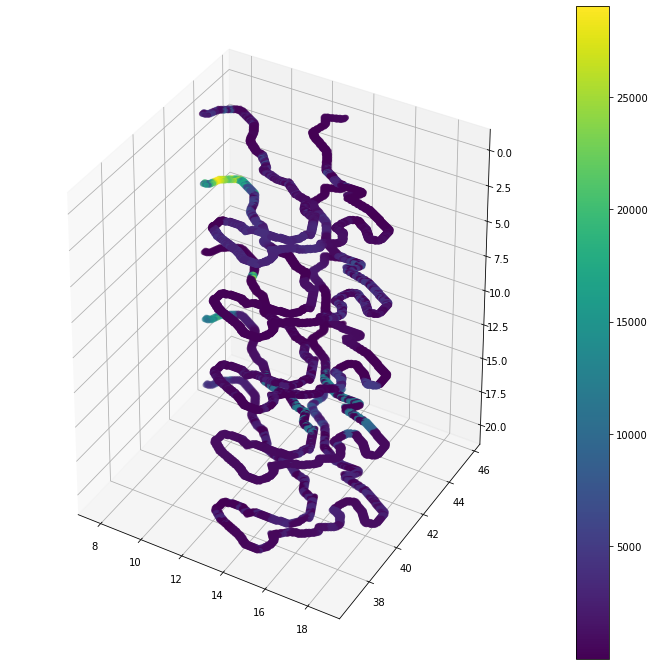

In [12]:
# 5. Visualize output.

# Show interpolation results

figure = plt.figure(figsize=(12, 12), facecolor='w')
ax = figure.add_subplot(111, projection='3d')
p = ax.scatter3D(interpolated[:, 0], interpolated[:, 1], interpolated[:, 2],
             c=interpolated[:, -1], cmap='viridis')
ax.invert_zaxis()
figure.colorbar(p)
plt.show()

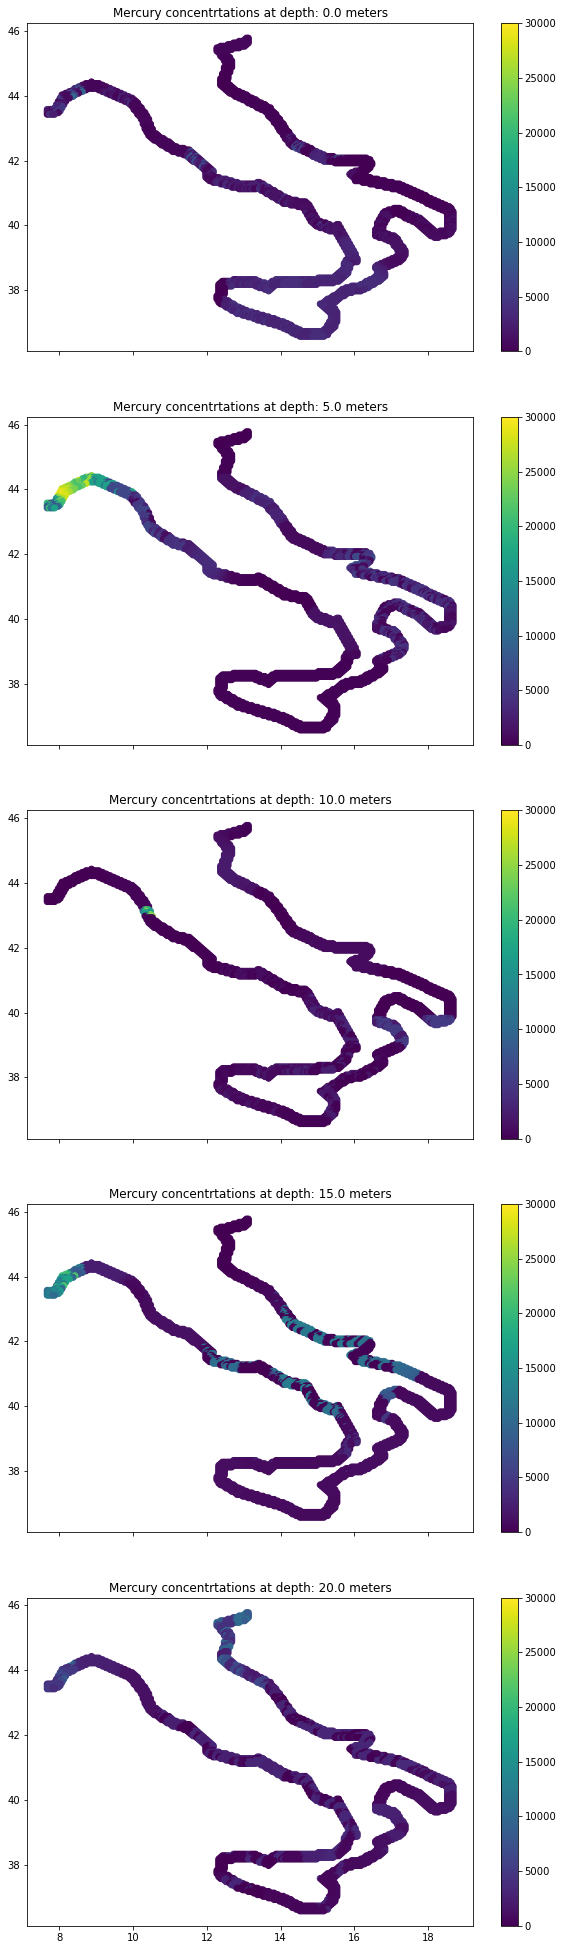

In [13]:
# 5. Visualize output - better style.

# Show interpolation results - as a subplots

# Get unique depths

unique_depths = np.unique(interpolated[:, 2])

# Prepare figures

scale = np.linspace(0, 30000, 300)
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(scale.min(), scale.max())
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

fig, axes = plt.subplots(nrows=5, ncols=1, sharex=True, figsize=(10, 35))

for idx, depth_level in enumerate(unique_depths):
    
    x = interpolated[:, 0][interpolated[:, 2] == depth_level]
    y = interpolated[:, 1][interpolated[:, 2] == depth_level]
    col = interpolated[:, -1][interpolated[:, 2] == depth_level]
    
    axes[idx].scatter(x, y, c=col, vmin=0, vmax=30000, cmap='viridis')
    axes[idx].set_title('Mercury concentrtations at depth: {} meters'.format(depth_level))
    
    fig.colorbar(sm, ax=axes[idx])